In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import h5py

import scipy.integrate as integrate
from matplotlib import mlab
from scipy.interpolate import interp1d
from scipy.fftpack import rfft

In [3]:
def get_psd(real_strain, sampling_rate=4096):

    # Define some constants
    nfft = 2 * sampling_rate  # Bigger values yield better resolution?

    # Use matplotlib.mlab to calculate the PSD from the real strain
    power_spectrum, frequencies = mlab.psd(real_strain,
                                           NFFT=nfft,
                                           Fs=sampling_rate)

    # Interpolate it linearly, so we can re-sample the spectrum arbitrarily
    psd = interp1d(frequencies, power_spectrum)

    return psd

## Read in the strain (only H1)

In [4]:
with h5py.File('../data/strain/H1_2017_4096.hdf5') as file:
    raw_strain = np.array(file['strain/Strain'])

## Read in and crop the waveforms

In [5]:
with h5py.File('../data/waveforms/waveforms_3s_0100_0300.h5') as file:
    
    # Empty list for the final, cropped waveforms
    waveforms = []
    
    # Read in the waveforms and the indices of the ones where the generation failed
    raw_waveforms = np.array(file['waveforms'])
    failed = np.array(file['failed'])
    
    # Remove failed waveforms
    raw_waveforms = np.array([raw_waveforms[i] for i in range(len(raw_waveforms)) if i not in failed])
    
    # Remove zero-padding from the waveforms
    for i in range(len(raw_waveforms)):
        waveform = raw_waveforms[i]
        for j in range(len(waveform)):
            if waveform[j] != 0:
                start = j
                break
        for j in range(len(waveform))[::-1]:
            if waveform[j] != 0:
                end = j
                break
        waveforms.append(waveform[start:end])

## Calculate SNR in the 'classical' way

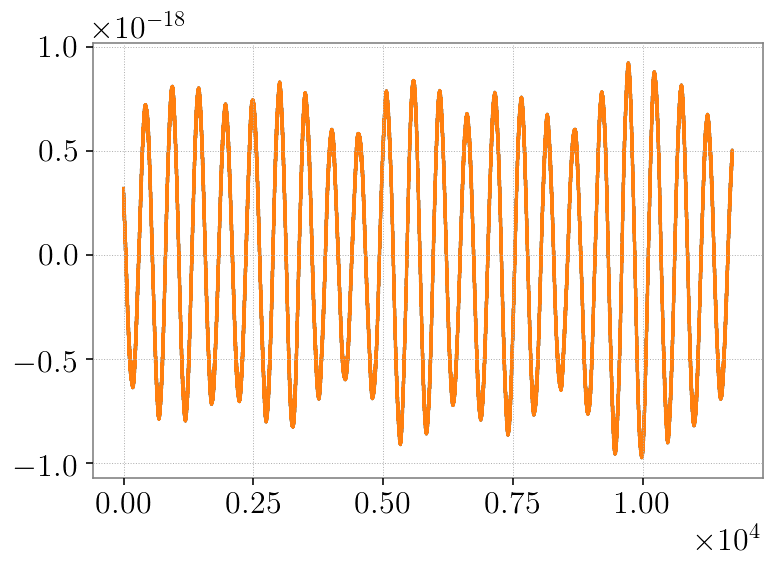

In [63]:
waveform = np.random.choice(waveforms)
start = int(np.random.uniform(0, len(raw_strain)-len(waveform)))
noise = raw_strain[start:start+len(waveform)]

signal = noise # + 0.0*waveform

plt.plot(signal)
plt.plot(noise)
plt.show()

In [52]:
power_signal = np.mean(np.square(np.abs(waveform)))
power_noise = np.mean(np.square(np.abs(noise)))

print('SNR = {}'.format(power_signal / power_noise))

SNR = 2.08418193856e-06


## Calculate SNR using the 'matched filtering' way

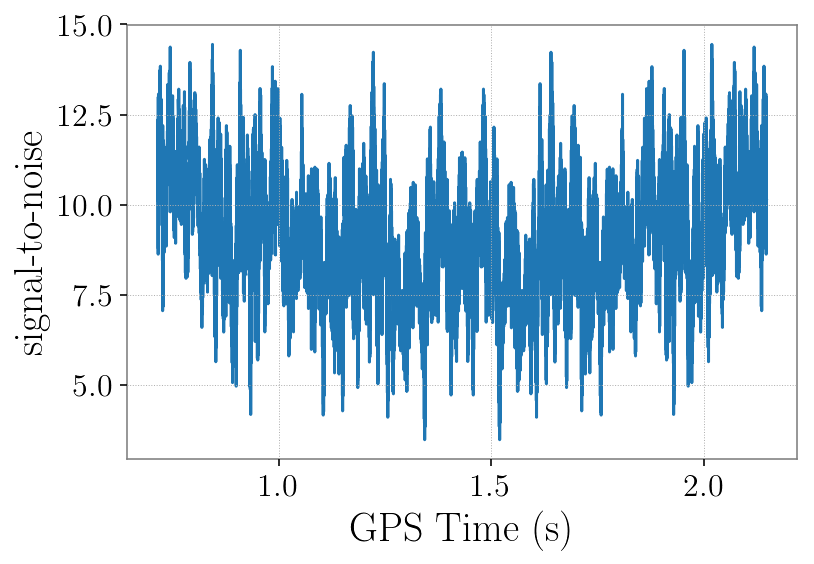

In [65]:
from pycbc.filter import matched_filter
from pycbc.types import TimeSeries
from pycbc.psd import welch, interpolate

raw_strain_ts = TimeSeries(raw_strain, delta_t=1.0/4096)
signal_ts = TimeSeries(signal, delta_t=1.0/4096)
noise_ts = TimeSeries(noise, delta_t=1.0/4096)
waveform_ts = TimeSeries(waveform, delta_t=1.0/4096)

# Calculate the complex (two-phase SNR)
psd = interpolate(welch(raw_strain_ts), delta_f=waveform_ts.delta_f)
snr = matched_filter(noise_ts, signal_ts, psd=psd)

snr = snr[len(snr) / 4: len(snr) * 3 / 4]

import pylab
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('signal-to-noise')
pylab.xlabel('GPS Time (s)')
pylab.show()